In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from transformers import AutoTokenizer, BertForPreTraining
import torch

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
model = BertForPreTraining.from_pretrained("google-bert/bert-base-uncased")

In [3]:
# example running the tokenizer and the model

inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
outputs = model(**inputs)

print(outputs)

BertForPreTrainingOutput(loss=None, prediction_logits=tensor([[[ -7.8962,  -7.8105,  -7.7903,  ...,  -7.0694,  -7.1693,  -4.3590],
         [ -8.4461,  -8.4401,  -8.5044,  ...,  -8.0625,  -7.9909,  -5.7160],
         [-15.2953, -15.4727, -15.5865,  ..., -12.9857, -11.7038, -11.4293],
         ...,
         [-14.0628, -14.2536, -14.3645,  ..., -12.7151, -11.1621, -10.2317],
         [-10.6576, -10.7892, -11.0402,  ..., -10.3233, -10.1578,  -3.7721],
         [-11.3383, -11.4590, -11.1767,  ...,  -9.2152,  -9.5209,  -9.5571]]],
       grad_fn=<ViewBackward0>), seq_relationship_logits=tensor([[ 3.3474, -2.0613]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)


In [4]:
# (batch_size, num_tokens (after, vocab_size)
outputs.prediction_logits.shape

torch.Size([1, 8, 30522])

In [5]:
# [CLS], [SEP] tokens are added
print(tokenizer.tokenize("Hello, my dog is cute", add_special_tokens=True))
print(inputs.input_ids)

['[CLS]', 'hello', ',', 'my', 'dog', 'is', 'cute', '[SEP]']
tensor([[  101,  7592,  1010,  2026,  3899,  2003, 10140,   102]])


In [6]:
token_idx = 4  #word: dog
pred_token = torch.argmax(outputs.prediction_logits[0][token_idx], dim=-1)
pred_token

tensor(3899)

In [7]:
[token for token, value in tokenizer.vocab.items() if value == pred_token]

['dog']

In [8]:
input_tokens = tokenizer.tokenize("Hello, my dog is cute", add_special_tokens=True)

for i in range(len(inputs.input_ids[0])):
    logits = outputs.prediction_logits[0][i]
    pred_token = torch.argmax(logits, dim=-1)
    word = [token for token, value in tokenizer.vocab.items() if value == pred_token]
    print(f'input token {input_tokens[i]} --- output word {word}')

input token [CLS] --- output word ['.']
input token hello --- output word ['.']
input token , --- output word [',']
input token my --- output word ['my']
input token dog --- output word ['dog']
input token is --- output word ['is']
input token cute --- output word ['.']
input token [SEP] --- output word ['.']


### Going into the model

In [9]:
model.bert.embeddings

BertEmbeddings(
  (word_embeddings): Embedding(30522, 768, padding_idx=0)
  (position_embeddings): Embedding(512, 768)
  (token_type_embeddings): Embedding(2, 768)
  (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [10]:
model.bert.embeddings(torch.tensor([[101]])).shape

torch.Size([1, 1, 768])

In [11]:
model.bert.embeddings.word_embeddings.weight.min()

tensor(-0.9504, grad_fn=<MinBackward1>)

In [12]:
model.bert.embeddings.word_embeddings.weight.max()

tensor(0.8729, grad_fn=<MaxBackward1>)

In [13]:
model_weights = torch.cat(tuple(model.bert.embeddings.word_embeddings.weight.squeeze()))

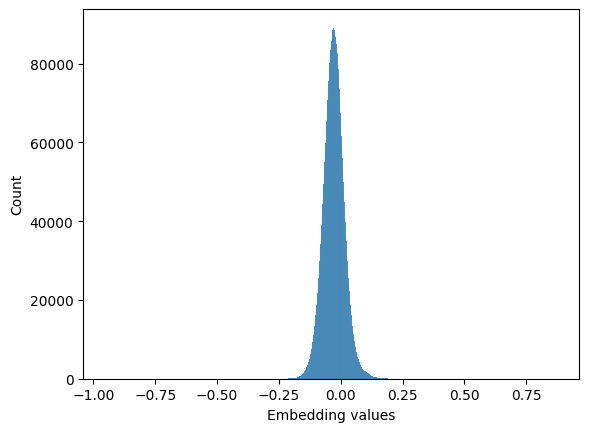

In [28]:
sns.histplot(model_weights.detach())
plt.xlabel('Embedding values')
plt.show()

In [15]:
pe_weights = torch.cat(tuple(model.bert.embeddings.position_embeddings.weight.squeeze()))

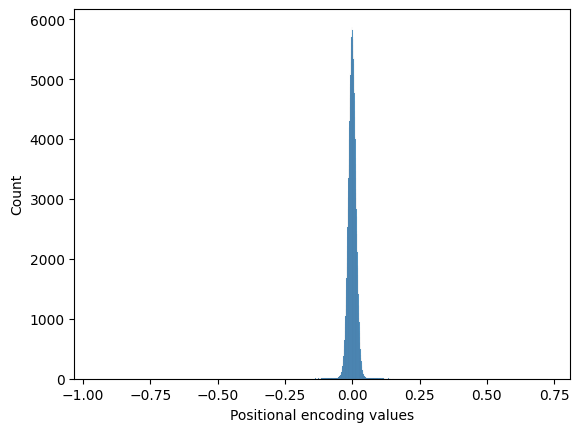

In [27]:
sns.histplot(pe_weights.detach())
plt.xlabel('Positional encoding values')
plt.show()

In [30]:
dog_embedding = model.bert.embeddings.word_embeddings(torch.tensor([[3899]]))
dog_pos = model.bert.embeddings.position_embeddings(torch.tensor(4))

In [31]:
dog_pos_embed = dog_pos + dog_embedding

In [32]:
dog_pos_embed.min().detach(), dog_pos_embed.max().detach()

(tensor(-0.1497), tensor(0.1432))

In [20]:
cosine = torch.nn.CosineSimilarity()
dog_embed_similarity = [cosine(vec.detach(), dog_pos_embed[0].detach()) for vec in model.bert.embeddings.word_embeddings.weight]

sim_idx = torch.argmax(torch.tensor(dog_embed_similarity))
[token for token, value in tokenizer.vocab.items() if value == sim_idx]

['dog']

In [21]:
def word_most_n_similar(input_vec, n=5):
    sims = [cosine(vec.detach(), input_vec[0].detach()) for vec in model.bert.embeddings.word_embeddings.weight]
    top_k = torch.topk(torch.tensor(sims), 5)
    top_indices = top_k.indices
    top_scores = top_k.values
    sim_tokens = [(token,value) for token, value in tokenizer.vocab.items() if value in top_indices]
    res ={}
    for word, token in sim_tokens:
        res[word] = top_scores[list(top_indices).index(token)]

    return dict(sorted(res.items(), key=lambda x: x[1], reverse=True))

In [22]:
word_most_n_similar(dog_embedding)

{'dog': tensor(1.0000),
 'dogs': tensor(0.7096),
 'cat': tensor(0.5082),
 'canine': tensor(0.5021),
 '##dog': tensor(0.4985)}

In [23]:
word_most_n_similar(dog_pos_embed)

{'dog': tensor(0.9063),
 'dogs': tensor(0.6429),
 'cat': tensor(0.4730),
 '##dog': tensor(0.4358),
 'horse': tensor(0.4352)}

In [24]:
dog_embedding = model.bert.embeddings.word_embeddings(torch.tensor([[3899]]))
dog_pos = model.bert.embeddings.position_embeddings(torch.tensor(0))
dog_pos_embed = dog_pos + dog_embedding
word_most_n_similar(dog_pos_embed)

{'[CLS]': tensor(0.8772),
 '[MASK]': tensor(0.5752),
 'dog': tensor(0.4465),
 '[SEP]': tensor(0.3790),
 'dogs': tensor(0.3727)}

In [25]:
# random token, and add the token type [1, 0], see hugginngface docs for more info
embedding = model.bert.embeddings.word_embeddings(torch.tensor([[2090]]))
pos = model.bert.embeddings.position_embeddings(torch.tensor(5))
token_type = model.bert.embeddings.token_type_embeddings(torch.tensor(0))
pos_embed_token = pos + embedding + token_type
norm = model.bert.embeddings.LayerNorm(pos_embed_token)
word_most_n_similar(norm)

{'between': tensor(0.8843),
 'among': tensor(0.2761),
 'both': tensor(0.2405),
 'separating': tensor(0.2284),
 'connecting': tensor(0.2021)}

In [37]:
# truncate the vectors to just the first 100 values

dog_embedding_100 = dog_embedding[0][0][:100].detach()
dog_pos_100 = dog_pos[:100].detach()
dog_pos_embed_100 = dog_embedding_100 + dog_pos_100


cosine = torch.nn.CosineSimilarity()

def word_most_n_similar_100(input_vec, n=5):
    sims = [cosine(vec[:100].detach(), input_vec.reshape(1, -1)) for vec in model.bert.embeddings.word_embeddings.weight]
    top_k = torch.topk(torch.tensor(sims), 5)
    top_indices = top_k.indices
    top_scores = top_k.values
    sim_tokens = [(token,value) for token, value in tokenizer.vocab.items() if value in top_indices]
    res ={}
    for word, token in sim_tokens:
        res[word] = top_scores[list(top_indices).index(token)]

    return dict(sorted(res.items(), key=lambda x: x[1], reverse=True))


word_most_n_similar_100(dog_embedding_100)

{'dog': tensor(1.),
 'dogs': tensor(0.7193),
 'canine': tensor(0.5656),
 'snake': tensor(0.5471),
 'cat': tensor(0.5462)}

In [38]:
word_most_n_similar_100(dog_pos_embed_100)

{'dog': tensor(0.8858),
 'dogs': tensor(0.5633),
 'rabbit': tensor(0.5006),
 'elephant': tensor(0.4879),
 'cat': tensor(0.4817)}

In [39]:
dog_pos_100.min(), dog_pos_100.max(), dog_pos_100.mean()

(tensor(-0.1186), tensor(0.0750), tensor(-0.0018))

In [40]:
dog_embedding_100.min(), dog_embedding_100.max(), dog_embedding_100.mean()

(tensor(-0.1000), tensor(0.0745), tensor(-0.0146))